<a href="https://colab.research.google.com/github/Flikersit/USVP/blob/main/Yauheni_Petrachenka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.io import wavfile
import requests
import random as rd
from requests.auth import HTTPDigestAuth
from IPython.display import Audio
from collections import namedtuple
from urllib.request import urlretrieve
import os
import pandas as pd
import numpy as np 
import librosa
import soundfile as sf
import wave
import scipy.io.wavfile as sw
import matplotlib.pyplot as plt

In [ ]:
# TTS-Service credentials
USERNAME = "kky_usvp"
PASSWORD = "queN7aex"

# TTS-Service API ROOT and available Czech voices and formats
TTS_ROOT = "https://services.speechtech.cz/tts/v3/synth"
VOICES_CS = ["Jan210", "Alena210", "Iva210", "Radka210", "Stanislav210", "Jiri210"]
FORMATS = ["mp3", "wav44kHz16bit"]

In [ ]:
# UWebASR API ROOT
ASR_ROOT = "https://uwebasr.zcu.cz/api/v1/"
def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

In [ ]:
def synthesize(out_fn, text, voice, fmt):
    """Synthesize the text into out_fn

    The voice of speech synthesis and the output format could be specified.

    Example:
    synthesize("test.wav", "hello world", "Jeremy210", "wav44kHz16bit")

    TTS-Server is provided by the company SpeechTech s.r.o.
    """
    r = requests.get(TTS_ROOT,
                     auth=HTTPDigestAuth(USERNAME, PASSWORD),
                     params={"text": text,
                             "engine": voice,
                             "format": fmt}
                    )
    r.raise_for_status()
    with open(out_fn, "wb") as fw:
        fw.write(r.content)

In [ ]:
def recognize(fn, model, words_only=False):
    """Recognizes the file fn using the UWebASR service

    The model must be supplied to identify the recognition model.

    If words_only is True, then the function returns array of words,
    otherwise it returns array of dictionaries containing more detailed
    recognition results.

    Example: 
    recognize("test.wav", "CLARIN_ASR/CZ")

    UWebASR service is provided by Department of Cybernetics, University of
    West Bohemia
    """
    with open(fn, "rb") as fr:
        r = requests.post(ASR_ROOT+model, data=fr, params={"format": "json"})
        r.raise_for_status()
        ret = r.json()
    if words_only:
        ret = [i["word"] for i in ret]
    return ret

In [ ]:
synthesize("test.wav", "Ahoj, jak se máš?", "Iva210", "wav44kHz16bit")
Audio("test.wav")

In [ ]:
recognize("test.wav", "CLARIN_ASR/CZ", words_only=True)

['Ahoj', 'jak', 'se', 'máš']

In [ ]:
OP_OK = 'o'
OP_SUB = 's'
OP_INS = 'i'
OP_DEL = 'd'

COST_SUB = 1
COST_INS = 1
COST_DEL = 1

def Levenshtein(vzor, test):
    """Calculates Levenshtein distance and corresponding edit operations"""
    m = len(vzor)
    n = len(test)
    vzor = [' ']+vzor
    test = [' ']+test

    last_row = [i*COST_INS for i in range(n+1)]
    last_row_op = [OP_INS*i for i in range(n+1)]

    for i in range(1, m+1):
        current = [i*COST_DEL]
        current_op = [OP_DEL*i]
        for j in range(1, n+1):
            if vzor[i] == test[j]:
                cost_sub = 0
                sub_op = OP_OK
            else:
                cost_sub = COST_SUB
                sub_op = OP_SUB
            cost_del = COST_INS
            cost_ins = COST_DEL
            min_cost, min_op = min(
                    [last_row[j]+cost_del, last_row_op[j]+OP_DEL],
                    [current[j-1]+cost_ins, current_op[j-1]+OP_INS],
                    [last_row[j-1]+cost_sub, last_row_op[j-1]+sub_op],
            )

            current.append(min_cost)
            current_op.append(min_op)
        last_row = current
        last_row_op = current_op

    return current[-1], current_op[-1]


In [ ]:
edit_counts = namedtuple("edit_counts", "N S D I H")

def calc_edit_ops(ref, hyp):
    """Calculates and returns number of edit operations

    N Number of tokens in the reference
    H Number of correctly recognized tokens
    S Number of substitutions
    D Number of deletions
    I Number of insertions
    """
    dist, ops = Levenshtein(ref, hyp)
    H = I = D = S = 0
    for op in ops:
        if op == OP_SUB:
            S += 1
        elif op == OP_DEL:
            D += 1
        elif op == OP_INS:
            I += 1
        elif op == OP_OK:
            H += 1
    N = len(ref)
    return edit_counts(N=N, S=S, D=D, I=I, H=H)

In [ ]:
e = calc_edit_ops(["ahoj", "jak", "se", "máš"], ["ahojky", "jak", "se"])

In [ ]:
print(e)
accuracy = (e.N-e.S-e.D-e.I)/e.N
print(accuracy)

edit_counts(N=4, S=1, D=1, I=0, H=2)
0.5


In [ ]:
INPUT_TEXT = """Provozovatel holešovské autoškoly Vladimír Dohnal popisuje rozhodnutí vlády o dřívějším otevření některých obchodů a provozoven za šílené a nepřipravené.
Kvůli šibeničnímu termínu tak v pondělí neotevřely některé zoologické zahrady či knihovny, byť už by mohly.
Přes víkend totiž většinou nestačily zajistit hygienická opatření nebo spustit online nákup vstupenek.
Regionální stanice Českého rozhlasu těžkosti některých provozovatelů zmapovaly.
"""


# Semestrální práce

## úkol 1
* Proveďte syntézu a rozpoznání na 10 řádkovém textu http://home.zcu.cz/~honzas/KKY_USVP.10.txt (kódování UTF-8). Použijte hlas "Alena210".
* Vyhodnoťte přesnost rozpoznávání (accuracy) - pro jednotlivé věty a celou sadu.
* Pozn.:
 * věta = řádka  (splitlines())
 * interpunkce - vliv na TTS a ASR  vs. vyhodnocení
 * doporučuji si poslechnout
 * výstup - tabulka v colab/jupyter notebooku

## úkol 2

*   Promyslete si několik způsobů zašumění akustického signálu (bílý šum, konvolutorní šum, přimíchání řeči na pozadí)
*   Pro každý ze způsobů zašumění připravte jako funkci:
```
def noise(fn, out_fn, intensity):
    "Tělo vaší funkce"
```
*   Zašumovací funkci zapojte do vašeho řetězce volání funkcí: TTS-ASR-evaluate
*   Proveďte syntézu a rozpoznání na 20 řádkovém textu http://home.zcu.cz/~honzas/KKY_USVP.20.txt (kódování UTF-8). *(můžete využít různé hlasy)*
*   Pro každou zašumovací funkci (případně hlas) vyhodnoťte celkovou přesnost rozpoznávání.
*   Způsob zašumění/hlas a odpovídající přesnost zobrazte v tabulce, případně graficky.

## úkol 3

*   Odpovězte na následující otázky:
 *   Proč i bez použití šumu je přesnost rozpoznávání menší než 100%?  
 *   Najděte 5 příkladů slov, které rozpoznávač nedokáže rozpoznat. Jak se tato chyba projeví na celkové přesnosti rozpoznávání? *(chyba rozpoznávání vs. OOV)*
 *   Při jaké chybovosti se již nedá pochopit význam výstupních hypotéz?






In [ ]:
#UKOL 1
download(" http://home.zcu.cz/~honzas/KKY_USVP.10.txt", "usvp1.txt")
f = open("usvp1.txt")
text = []
synth = []
roz = []
vys = []
n = []
h = []
d = []
s = []
ins = []
n1 = []
h1 = []
d1 = []
s1 = []
ins1 = []
acc = []
acc1 = []
for line in f:
  text.append(line.splitlines())
text1 = text.copy()
for k in range(len(text1)):
  text1[k][0] = text[k][0].lower()
  if "," in text1[k][0]:
    text1[k][0] = text[k][0].replace(",", "")
  if "." in text1[k][0]:
    text[k][0] = text[k][0].replace(".", "")
  if "?" in text1[k][0]:
    text1[k][0] = text[k][0].replace("?", "")
  if "-" in text[k][0]:
    text[k][0] = text[k][0].replace("-", "")
print(roz)
for m in range(len(text1)):
  vys.append(text1[m][0].split())
for i in range(len(vys)):
  synthesize("out_fn.wav", text[i][0], "Alena210", "wav44kHz16bit")
  rec = recognize("out_fn.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec)
  n.append(e.N)
  h.append(e.H)
  d.append(e.D)
  s.append(e.S)
  ins.append(e.I)
  acc.append((e.N-e.S-e.D-e.I)/e.N)
  synthesize("out.wav", text1[i][0], "Alena210", "wav44kHz16bit")
  rec = recognize("out.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec)
  n1.append(e.N)
  h1.append(e.H)
  d1.append(e.D)
  s1.append(e.S)
  ins1.append(e.I)
  acc1.append((e.N-e.S-e.D-e.I)/e.N)
Data = {"N":n, "H inter":h,"H":h1 ,"S inter":s,"S":s1, "D inter":d,"D":d1, "I inter":ins,"I":ins1, "Acc inter":acc, "Acc":acc1}
result = pd.DataFrame(Data)
print (result)
print("Total accuracy", (sum(n)-sum(s)-sum(d)-sum(ins))/sum(n))

Download file... usvp1.txt ...
File downloaded
[]
    N  H inter   H  S inter  S  D inter  D  I inter  I  Acc inter       Acc
0  33       29  29        2  2        2  2        0  0   0.878788  0.878788
1   5        5   5        0  0        0  0        0  0   1.000000  1.000000
2  59       58  58        1  1        0  0        0  0   0.983051  0.983051
3   3        2   2        1  1        0  0        0  0   0.666667  0.666667
4  28       28  28        0  0        0  0        0  0   1.000000  1.000000
5  22       21  21        1  1        0  0        0  0   0.954545  0.954545
6  20       20  20        0  0        0  0        0  0   1.000000  1.000000
7   5        5   5        0  0        0  0        0  0   1.000000  1.000000
8   7        7   7        0  0        0  0        0  0   1.000000  1.000000
9  30       30  30        0  0        0  0        0  0   1.000000  1.000000
Total accurancy 0.9669811320754716


Alena210
         Acc
0   0.595238
1   0.666667
2   0.803030
3   0.250000
4   0.714286
5   0.703704
6   0.826087
7   0.571429
8   0.750000
9   0.750000
10  0.803571
11  0.500000
12  0.673913
13  0.642857
14  0.333333
15  0.696970
16  0.606061
17  0.666667
18  0.500000
19  0.571429


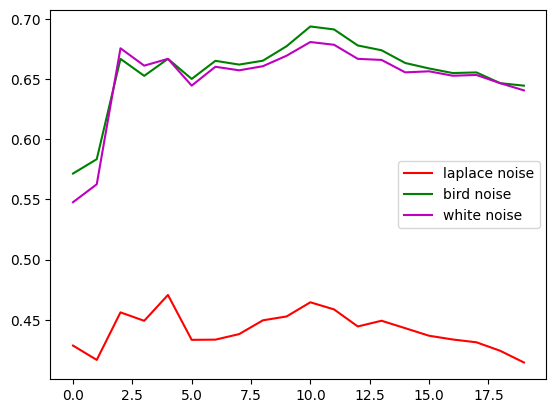

Jiri210
         Acc
0   0.595238
1   0.666667
2   0.787879
3   0.250000
4   0.714286
5   0.703704
6   0.782609
7   0.571429
8   0.750000
9   0.750000
10  0.803571
11  0.500000
12  0.695652
13  0.642857
14  0.333333
15  0.666667
16  0.636364
17  0.666667
18  0.454545
19  0.500000


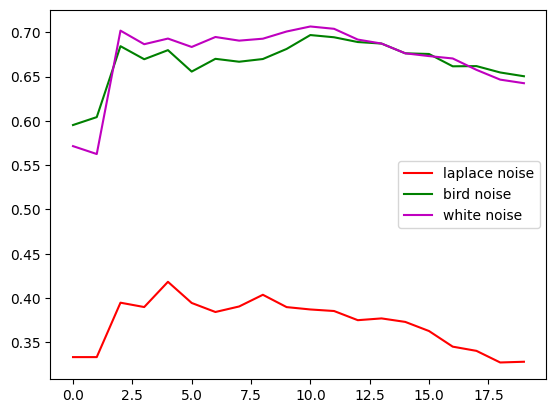

Jan210
         Acc
0   0.595238
1   0.666667
2   0.757576
3   0.250000
4   0.714286
5   0.666667
6   0.782609
7   0.571429
8   0.750000
9   0.750000
10  0.839286
11  0.500000
12  0.673913
13  0.642857
14  0.333333
15  0.696970
16  0.666667
17  0.666667
18  0.500000
19  0.571429


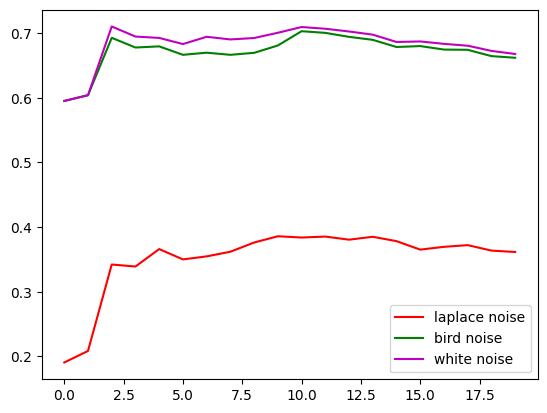

In [ ]:
#UKOL 2
def white_noise(fn, out_fn ,intensity):
  y, sr = librosa.load(fn)
  noise = np.array([rd.gauss(1*intensity, 0.2*intensity) for i in range(len(y))])
  signal = y + noise
  sf.write(out_fn, signal, sr, subtype = "PCM_16")

def bird_noise(fn, out_fn):
  y, sr = librosa.load(fn)
  z, sr = librosa.load("audio.wav")
  if len(y)>len(z):
    dot = len(y)//len(z)
    add = len(y)%len(z)
    concat = np.tile(z, dot)
    if add!=0:
      concat = np.concatenate(concat, np.array(z[0:add]))
  if len(y)<len(z):
    add = len(y)%len(z)
    concat = np.array(z[0:add])
  if len(y) == len(z):
    concat = z
  vysl = concat + y
  sf.write(out_fn, vysl, sr, subtype = "PCM_16")


def laplace_noise(fn, fn_out, intensity):
    signal, sr = librosa.load(fn, sr = 44100)
    SNR = intensity
    RMS = np.sqrt(np.mean(signal**2))
    RMS_n = np.sqrt((RMS**2)/(10**(SNR/10)))
    noise = np.random.laplace(0, RMS_n, signal.shape[0])
    sw.write('noise_l.wav', 44100, noise)
    y1, sr1 = librosa.load('noise_l.wav', sr = 44100)
    y2, sr2 = librosa.load(fn, sr = 44100)
    result = (y1+y2)/2
    sw.write(fn_out, 44100, result)

download("http://home.zcu.cz/~honzas/KKY_USVP.20.txt", "usvp2.txt")
n = [[], [], []]
h = [[], [], []]
d = [[], [], []]
s = [[], [], []]
I = [[], [], []]
text3 = []
acc_l = []
acc_w = []
acc_b = []
acc = []
vys = []
f = open("usvp2.txt")
for line in f:
  text3.append(line.splitlines())
for m in range(len(text3)):
  vys.append(text3[m][0].split())
for i in range(len(vys)):
  synthesize("out_fn_1.wav", text3[i][0], "Alena210", "wav44kHz16bit")
  rec = recognize("out_fn_1.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec)
  acc.append((e.N-e.S-e.D-e.I)/e.N)
Data1 = {"Acc":acc}
result1 = pd.DataFrame(Data1)
print("Alena210")
print(result1)
for i in range(len(vys)):
  synthesize("out_fn.wav", text3[i][0], "Alena210", "wav44kHz16bit")
  laplace_noise("out_fn.wav", "lnoise.wav", 0.1)
  white_noise("out_fn.wav", "white.wav", 0.1)
  bird_noise("out_fn.wav", "bird.wav")
  rec1 = recognize("lnoise.wav", "CLARIN_ASR/CZ", words_only=True)
  rec2 = recognize("white.wav", "CLARIN_ASR/CZ", words_only=True)
  rec3 = recognize("bird.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec1)
  n[0].append(e.N)
  h[0].append(e.H)
  d[0].append(e.D)
  s[0].append(e.S)
  I[0].append(e.I)
  acc_l.append((sum(n[0])-sum(s[0])-sum(d[0])-sum(I[0]))/sum(n[0]))
  e = calc_edit_ops(vys[i], rec2)
  n[1].append(e.N)
  h[1].append(e.H)
  d[1].append(e.D)
  s[1].append(e.S)
  I[1].append(e.I)
  acc_w.append((sum(n[1])-sum(s[1])-sum(d[1])-sum(I[1]))/sum(n[1]))
  e = calc_edit_ops(vys[i], rec3)
  n[2].append(e.N)
  h[2].append(e.H)
  d[2].append(e.D)
  s[2].append(e.S)
  I[2].append(e.I)
  acc_b.append((sum(n[2])-sum(s[2])-sum(d[2])-sum(I[2]))/sum(n[2]))
X = np.arange(20)
plt.plot(X, acc_l, color='r', label='laplace')
plt.plot(X, acc_b, color='g', label='bird')
plt.plot(X, acc_w, color ='m', label='white')
plt.legend(['laplace noise', 'bird noise', 'white noise'])
plt.show()
n = [[], [], []]
h = [[], [], []]
d = [[], [], []]
s = [[], [], []]
I = [[], [], []]
acc_l = []
acc_w = []
acc_b = []
acc = []
for i in range(len(vys)):
  synthesize("out_fn_1.wav", text3[i][0], "Jiri210", "wav44kHz16bit")
  rec = recognize("out_fn_1.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec)
  acc.append((e.N-e.S-e.D-e.I)/e.N)
Data1 = {"Acc":acc}
result1 = pd.DataFrame(Data1)
print("Jiri210")
print(result1)
for i in range(len(vys)):
  synthesize("out_fn.wav", text3[i][0], "Jiri210", "wav44kHz16bit")
  laplace_noise("out_fn.wav", "lnoise.wav", 0.1)
  white_noise("out_fn.wav", "white.wav", 0.1)
  bird_noise("out_fn.wav", "bird.wav")
  rec1 = recognize("lnoise.wav", "CLARIN_ASR/CZ", words_only=True)
  rec2 = recognize("white.wav", "CLARIN_ASR/CZ", words_only=True)
  rec3 = recognize("bird.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec1)
  n[0].append(e.N)
  h[0].append(e.H)
  d[0].append(e.D)
  s[0].append(e.S)
  I[0].append(e.I)
  acc_l.append((sum(n[0])-sum(s[0])-sum(d[0])-sum(I[0]))/sum(n[0]))
  e = calc_edit_ops(vys[i], rec2)
  n[1].append(e.N)
  h[1].append(e.H)
  d[1].append(e.D)
  s[1].append(e.S)
  I[1].append(e.I)
  acc_w.append((sum(n[1])-sum(s[1])-sum(d[1])-sum(I[1]))/sum(n[1]))
  e = calc_edit_ops(vys[i], rec3)
  n[2].append(e.N)
  h[2].append(e.H)
  d[2].append(e.D)
  s[2].append(e.S)
  I[2].append(e.I)
  acc_b.append((sum(n[2])-sum(s[2])-sum(d[2])-sum(I[2]))/sum(n[2]))
X = np.arange(20)
plt.plot(X, acc_l, color='r', label='laplace')
plt.plot(X, acc_b, color='g', label='bird')
plt.plot(X, acc_w, color ='m', label='white')
plt.legend(['laplace noise', 'bird noise', 'white noise'])
plt.show()
n = [[], [], []]
h = [[], [], []]
d = [[], [], []]
s = [[], [], []]
I = [[], [], []]
acc_l = []
acc_w = []
acc_b = []
acc = []
for i in range(len(vys)):
  synthesize("out_fn_1.wav", text3[i][0], "Jan210", "wav44kHz16bit")
  rec = recognize("out_fn_1.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec)
  acc.append((e.N-e.S-e.D-e.I)/e.N)
Data1 = {"Acc":acc}
result1 = pd.DataFrame(Data1)
print("Jan210")
print(result1)
for i in range(len(vys)):
  synthesize("out_fn.wav", text3[i][0], "Jan210", "wav44kHz16bit")
  laplace_noise("out_fn.wav", "lnoise.wav", 0.1)
  white_noise("out_fn.wav", "white.wav", 0.1)
  bird_noise("out_fn.wav", "bird.wav")
  rec1 = recognize("lnoise.wav", "CLARIN_ASR/CZ", words_only=True)
  rec2 = recognize("white.wav", "CLARIN_ASR/CZ", words_only=True)
  rec3 = recognize("bird.wav", "CLARIN_ASR/CZ", words_only=True)
  e = calc_edit_ops(vys[i], rec1)
  n[0].append(e.N)
  h[0].append(e.H)
  d[0].append(e.D)
  s[0].append(e.S)
  I[0].append(e.I)
  acc_l.append((sum(n[0])-sum(s[0])-sum(d[0])-sum(I[0]))/sum(n[0]))
  e = calc_edit_ops(vys[i], rec2)
  n[1].append(e.N)
  h[1].append(e.H)
  d[1].append(e.D)
  s[1].append(e.S)
  I[1].append(e.I)
  acc_w.append((sum(n[1])-sum(s[1])-sum(d[1])-sum(I[1]))/sum(n[1]))
  e = calc_edit_ops(vys[i], rec3)
  n[2].append(e.N)
  h[2].append(e.H)
  d[2].append(e.D)
  s[2].append(e.S)
  I[2].append(e.I)
  acc_b.append((sum(n[2])-sum(s[2])-sum(d[2])-sum(I[2]))/sum(n[2]))
X = np.arange(20)
plt.plot(X, acc_l, color='r', label='laplace')
plt.plot(X, acc_b, color='g', label='bird')
plt.plot(X, acc_w, color ='m', label='white')
plt.legend(['laplace noise', 'bird noise', 'white noise'])
plt.show()

Ukol 3

1) Ne všichni slova jsou ve slovníku, což ovlivňuje přesnost rozpoznávání, například zkratky, vlastní jména, taky hlas má vliv na přesnost rozpoznávání

2) Špatné rozpoznávání snižuje přesnost rozpoznávání. Příklady takových slov brexitu - Brexitu, Weil - Reil, Evropské unie - EU, Maa - má, pětset - 500.

3) Záleží na typu chyby. V případě zanedbávání velkých písmen budeme mít vliv na přesnost rozpoznávání ale nebudeme mít vliv na pochopení slov. Problém bude s konkrétními slovy, jako jména, slang, které nejsou ve slovníku atd. Taková slova budou špatně rozpoznané nebo vůbec nerozpoznané, co silně ovlivní celkovou pochopitelnost.
```
# This is formatted as code
```

